In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/Shareddrives/COSC525_Group8/Colab/Brain_Tumor_large.zip"
output_dir = '/content'
!unzip '{dataset_path}' -d '{output_dir}'

Streaming output truncated to the last 5000 lines.
  inflating: /content/Brain_Tumor_large/Training/glioma_tumor/Tr-gl_0715.jpg  
  inflating: /content/Brain_Tumor_large/Training/glioma_tumor/Tr-gl_0716.jpg  
  inflating: /content/Brain_Tumor_large/Training/glioma_tumor/Tr-gl_0717.jpg  
  inflating: /content/Brain_Tumor_large/Training/glioma_tumor/Tr-gl_0718.jpg  
  inflating: /content/Brain_Tumor_large/Training/glioma_tumor/Tr-gl_0719.jpg  
  inflating: /content/Brain_Tumor_large/Training/glioma_tumor/Tr-gl_0720.jpg  
  inflating: /content/Brain_Tumor_large/Training/glioma_tumor/Tr-gl_0721.jpg  
  inflating: /content/Brain_Tumor_large/Training/glioma_tumor/Tr-gl_0722.jpg  
  inflating: /content/Brain_Tumor_large/Training/glioma_tumor/Tr-gl_0723.jpg  
  inflating: /content/Brain_Tumor_large/Training/glioma_tumor/Tr-gl_0724.jpg  
  inflating: /content/Brain_Tumor_large/Training/glioma_tumor/Tr-gl_0725.jpg  
  inflating: /content/Brain_Tumor_large/Training/glioma_tumor/Tr-gl_0726.jpg  
 

In [ ]:
import os, pathlib
import random
import cv2

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

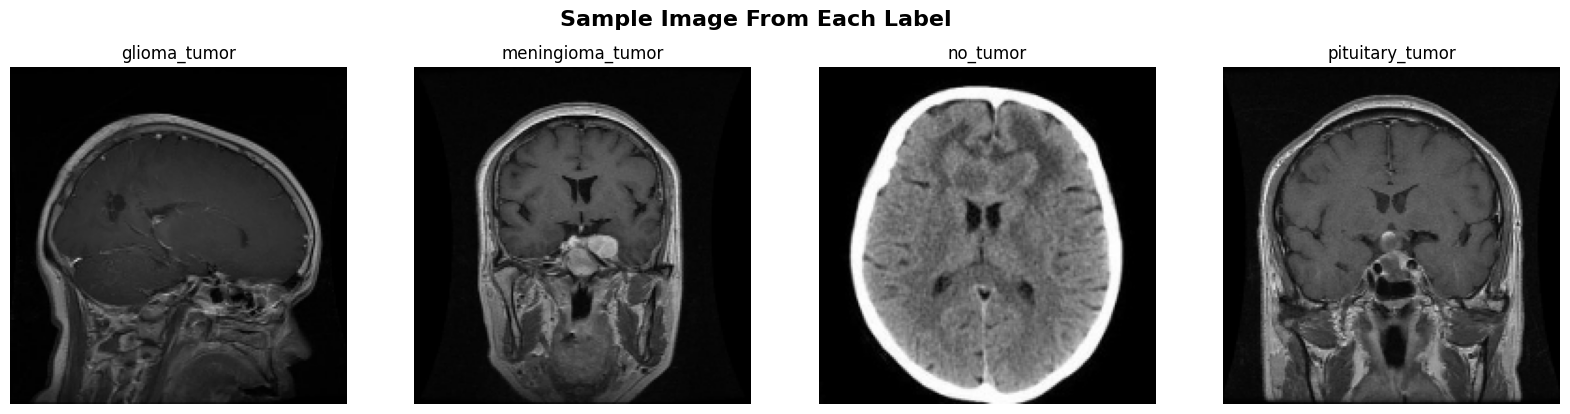

In [ ]:
labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

sample_images = []
# Get a sample image from each class
for label in labels:
    base_dir = f"Brain_Tumor_large/Training/{label}"
    img_file = random.choice(os.listdir(base_dir))
    img_path = os.path.join(base_dir, img_file)
    image = cv2.imread(img_path)
    image = cv2.resize(image, (180, 180))
    sample_images.append(image)

# Plot the sample images
fig, ax = plt.subplots(1, 4, figsize=(20,20))
fig.text(s='Sample Image From Each Label', size=16, fontweight='bold', y=0.6, x=0.4)
for i in range(4):
    ax[i].imshow(sample_images[i])
    ax[i].set_title(labels[i])
    ax[i].axis("off")
plt.show()

In [ ]:
labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

base_dir = pathlib.Path("Brain_Tumor_large")

# Generate batches for training and validation (80/20 split)
train_dataset, validation_dataset = image_dataset_from_directory(base_dir / "Training",
                                                                 class_names=labels,
                                                                 image_size=(180, 180),
                                                                 batch_size=64,
                                                                 validation_split=0.2,
                                                                 subset="both",
                                                                 seed=42)

# Generate batches for testing
test_dataset = image_dataset_from_directory(base_dir / "Testing",
                                            class_names=labels,
                                            image_size=(180, 180),
                                            batch_size=64,
                                            seed=42)

# Display the shapes of data and labels yielded by Dataset
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
data batch shape: (64, 180, 180, 3)
labels batch shape: (64,)


# Model 1 - Custom CNN

In [ ]:
# Label-preserving transformations
data_augmentation = keras.Sequential([
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.GaussianNoise(0.05),
    layers.RandomTranslation(0.1, 0.1),])

In [ ]:
# Build model structure
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)

    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Show model structure
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 180, 180,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 176, 176,  │      2,400 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 176, 176,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 176, 176,  │      1,312 │ activation[0][0]  │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 176,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 176, 176,  │      1,312 │ activation_1[0][… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 88, 88,    │          0 │ separable_conv2d… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 88, 88,    │      1,024 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 88, 88,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        128 │ add[0][0]         │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 88, 88,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 88, 88,    │      2,336 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        256 │ separable_conv2d

 Total params: 723,396 (2.76 MB)

 Trainable params: 720,388 (2.75 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [ ]:
# Configure loss function, optimizer and monitoring metric
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
# Create checkpoints to save the best model
callbacks = [keras.callbacks.ModelCheckpoint(filepath="custom_model.keras",
                                             save_best_only=True,
                                             monitor="val_loss")]

# Train the model
history = model.fit(train_dataset,
                    epochs=75,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 73s 975ms/step - accuracy: 0.5131 - loss: 1.0785 - val_accuracy: 0.2137 - val_loss: 1.4188
Epoch 2/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 69s 955ms/step - accuracy: 0.6563 - loss: 0.7976 - val_accuracy: 0.2653 - val_loss: 1.5290
Epoch 3/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 68s 950ms/step - accuracy: 0.7370 - loss: 0.6808 - val_accuracy: 0.2137 - val_loss: 1.6629
Epoch 4/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 69s 960ms/step - accuracy: 0.7964 - loss: 0.5475 - val_accuracy: 0.3722 - val_loss: 1.8973
Epoch 5/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 68s 949ms/step - accuracy: 0.8391 - loss: 0.4218 - val_accuracy: 0.2364 - val_loss: 2.6569
Epoch 6/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 69s 956ms/step - accuracy: 0.8462 - loss: 0.4127 - val_accuracy: 0.3380 - val_loss: 2.5555
Epoch 7/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 68s 947ms/step - accuracy: 0.8637 - loss: 0.3722 - val_accuracy: 0.2592 - val_loss: 4.4245
Epoch 8/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 69s 958ms/step - accuracy: 0.8947 - loss: 0.2880 - val_accu

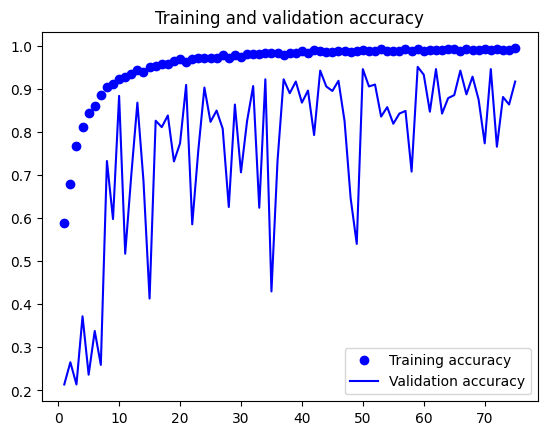

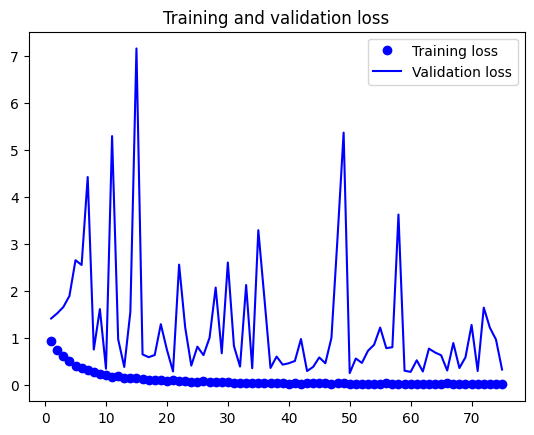

In [ ]:
# Display curves of accuracy and loss during training
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# Load the best model
best_model = keras.models.load_model("custom_model.keras")

test_preds = []
test_truths = []

for data_batch, labels_batch in test_dataset:
    # Perform predictions on the test set
    preds = best_model.predict_on_batch(data_batch)
    preds = preds.argmax(axis=1)
    test_preds.append(preds)
    # Get true labels of the test set
    numpy_labels = labels_batch.numpy()
    test_truths.append(numpy_labels)

test_preds = np.concatenate(test_preds, axis=0)
test_truths = np.concatenate(test_truths, axis=0)

In [ ]:
# Evaluate the performance on test set
metrics = classification_report(test_truths, test_preds, target_names=labels)
print(metrics)

                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.98      0.96       300
meningioma_tumor       0.96      0.93      0.95       306
        no_tumor       0.99      1.00      0.99       405
 pituitary_tumor       1.00      0.97      0.98       300

        accuracy                           0.97      1311
       macro avg       0.97      0.97      0.97      1311
    weighted avg       0.97      0.97      0.97      1311



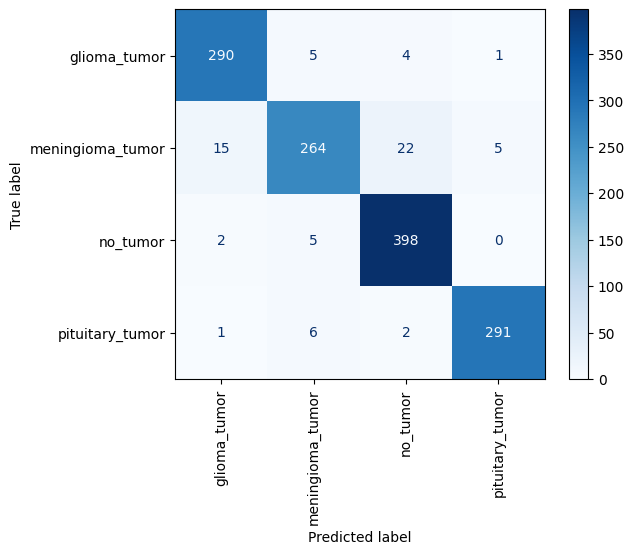

In [ ]:
# Plot confusion matrix
conf_mat = confusion_matrix(test_truths, test_preds)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
conf_mat_disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.show()

# Model 2 - Custom CNN

In [ ]:
# Label-preserving transformations (improved)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.GaussianNoise(0.05),
    layers.RandomTranslation(0.1, 0.1),
])

In [ ]:
# Build improved model structure
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=7, strides=2, padding="same", use_bias=False)(x)

for i, size in enumerate([32, 64, 128, 256, 512]):
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=6)(x)  # ReLU6

    if i < 2:
        x = layers.Conv2D(size, 3, padding="same", use_bias=False,
                          kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    else:
        x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False,
                                   depthwise_regularizer=keras.regularizers.l2(1e-4),
                                   pointwise_regularizer=keras.regularizers.l2(1e-4))(x)

    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=6)(x)  # ReLU6 again

    if i < 2:
        x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)
    else:
        x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Configure loss function, optimizer and monitoring metric
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Create checkpoints to save the best model
callbacks = [keras.callbacks.ModelCheckpoint(filepath="custom_model.keras",
                                             save_best_only=True,
                                             monitor="val_loss")]

# Train the model
history = model.fit(train_dataset,
                    epochs=75,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 0.4535 - loss: 1.9159 - val_accuracy: 0.2636 - val_loss: 1.4297
Epoch 2/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.6083 - loss: 0.9945 - val_accuracy: 0.2172 - val_loss: 1.4931
Epoch 3/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.7261 - loss: 0.7585 - val_accuracy: 0.2207 - val_loss: 1.5444
Epoch 4/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.7634 - loss: 0.6644 - val_accuracy: 0.2925 - val_loss: 1.5262
Epoch 5/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.7886 - loss: 0.5980 - val_accuracy: 0.4816 - val_loss: 1.5688
Epoch 6/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.8275 - loss: 0.4888 - val_accuracy: 0.6322 - val_loss: 1.0161
Epoch 7/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.8651 - loss: 0.4303 - val_accuracy: 0.5998 - val_loss: 1.2182
Epoch 8/75
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.8829 - loss: 0.3640 - val_accu

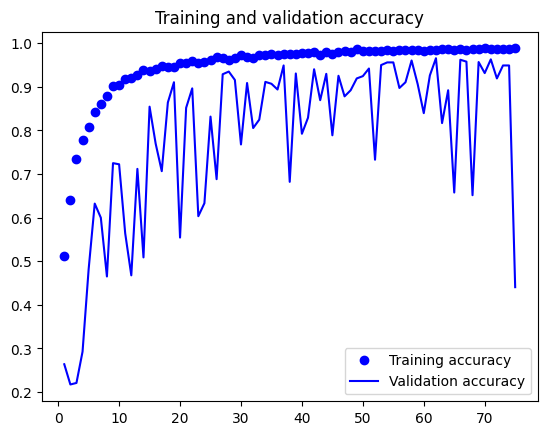

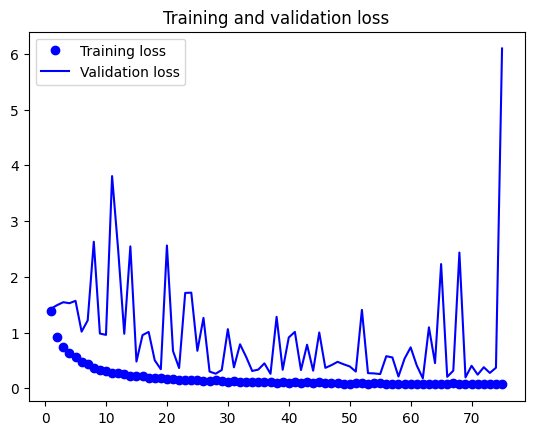

In [ ]:
# Display curves of accuracy and loss during training
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.98      0.97       300
meningioma_tumor       0.98      0.89      0.93       306
        no_tumor       0.97      1.00      0.98       405
 pituitary_tumor       0.97      0.99      0.98       300

        accuracy                           0.97      1311
       macro avg       0.97      0.96      0.96      1311
    weighted avg       0.97      0.97      0.97      1311



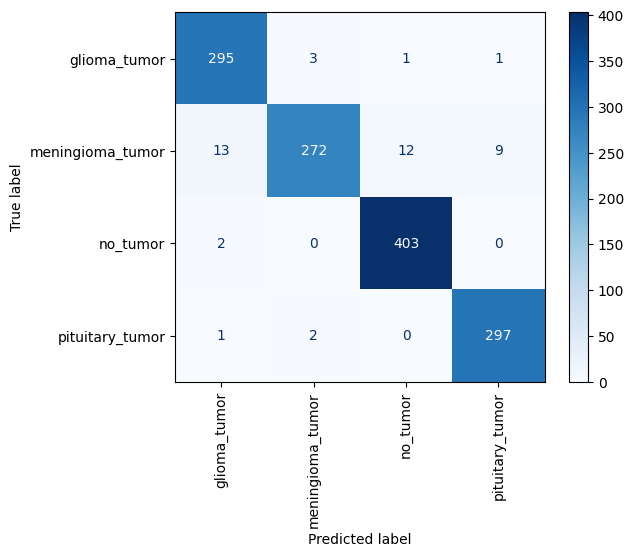

In [ ]:
# Load the best model
best_model = keras.models.load_model("custom_model.keras")

test_preds = []
test_truths = []

for data_batch, labels_batch in test_dataset:
    # Perform predictions on the test set
    preds = best_model.predict_on_batch(data_batch)
    preds = preds.argmax(axis=1)
    test_preds.append(preds)
    # Get true labels of the test set
    numpy_labels = labels_batch.numpy()
    test_truths.append(numpy_labels)

test_preds = np.concatenate(test_preds, axis=0)
test_truths = np.concatenate(test_truths, axis=0)

# Evaluate the performance on test set
metrics = classification_report(test_truths, test_preds, target_names=labels)
print(metrics)

# Plot confusion matrix
conf_mat = confusion_matrix(test_truths, test_preds)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
conf_mat_disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.show()

# Model 3 - EfficientNetB0

In [ ]:
# Label-preserving transformations
data_augmentation = keras.Sequential([
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.GaussianNoise(0.05),
    layers.RandomTranslation(0.1, 0.1),])

In [ ]:
# Instantiate convolutional base of EfficientNetB0
conv_base = keras.applications.EfficientNetB0(weights="imagenet",
                                              include_top=False)

In [ ]:
# Show the structure of convolutional base
conv_base.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, None, None, 3)        0         ['input_5[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, None, None, 3)        7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, None, None, 3)        0         ['normalization_2

In [ ]:
# Build model structure
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Show model structure
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
# Configure loss function, optimizer and monitoring metric
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
# Create checkpoints to save the best model
callbacks = [keras.callbacks.ModelCheckpoint(filepath="efficientnetb0.keras",
                                             save_best_only=True,
                                             monitor="val_loss")]

# Train the model
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/20
72/72 [==============================] - 35s 429ms/step - loss: 0.0958 - accuracy: 0.9698 - val_loss: 0.1652 - val_accuracy: 0.9562
Epoch 2/20
72/72 [==============================] - 29s 406ms/step - loss: 0.0919 - accuracy: 0.9683 - val_loss: 0.1816 - val_accuracy: 0.9562
Epoch 3/20
72/72 [==============================] - 30s 413ms/step - loss: 0.0920 - accuracy: 0.9696 - val_loss: 0.1909 - val_accuracy: 0.9545
Epoch 4/20
72/72 [==============================] - 29s 405ms/step - loss: 0.0851 - accuracy: 0.9720 - val_loss: 0.1960 - val_accuracy: 0.9545
Epoch 5/20
72/72 [==============================] - 29s 395ms/step - loss: 0.0971 - accuracy: 0.9716 - val_loss: 0.1977 - val_accuracy: 0.9545
Epoch 6/20
72/72 [==============================] - 28s 394ms/step - loss: 0.0834 - accuracy: 0.9694 - val_loss: 0.1989 - val_accuracy: 0.9545
Epoch 7/20
72/72 [==============================] - 29s 395ms/step - loss: 0.0734 - accuracy: 0.9718 - val_loss: 0.1997 - val_accuracy: 0.9545

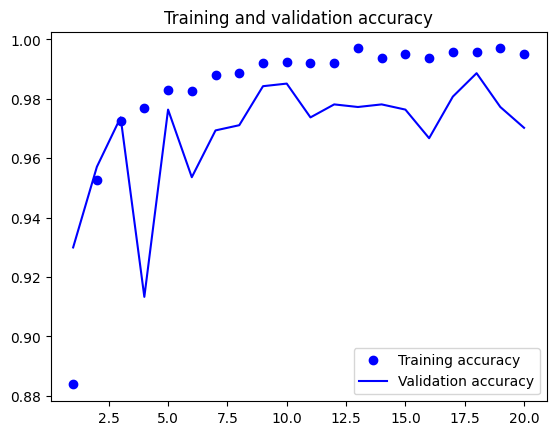

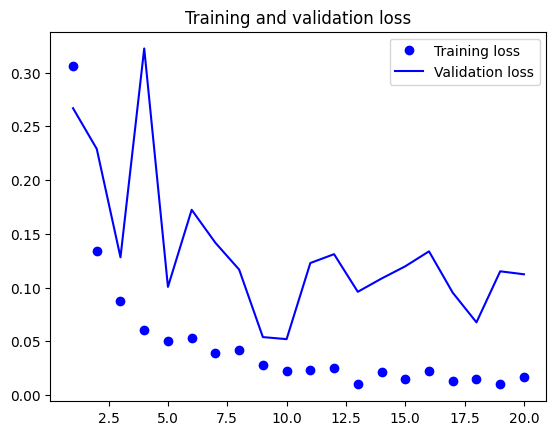

In [ ]:
# Display curves of accuracy and loss during training
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# Load the best model
best_model = keras.models.load_model("efficientnetb0.keras")

test_preds = []
test_truths = []

for data_batch, labels_batch in test_dataset:
    # Perform predictions on the test set
    preds = best_model.predict_on_batch(data_batch)
    preds = preds.argmax(axis=1)
    test_preds.append(preds)
    # Get true labels of the test set
    numpy_labels = labels_batch.numpy()
    test_truths.append(numpy_labels)

test_preds = np.concatenate(test_preds, axis=0)
test_truths = np.concatenate(test_truths, axis=0)

In [ ]:
# Evaluate the performance on test set
metrics = classification_report(test_truths, test_preds, target_names=labels)
print(metrics)

                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.96      0.98       300
meningioma_tumor       0.94      0.98      0.96       306
        no_tumor       1.00      0.99      1.00       405
 pituitary_tumor       0.99      0.99      0.99       300

        accuracy                           0.98      1311
       macro avg       0.98      0.98      0.98      1311
    weighted avg       0.98      0.98      0.98      1311



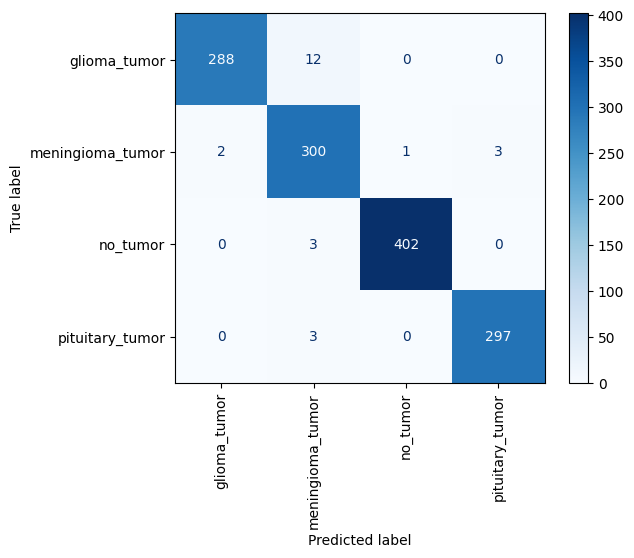

In [ ]:
# Plot confusion matrix
conf_mat = confusion_matrix(test_truths, test_preds)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
conf_mat_disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.show()

# Model 4 - EfficientNetB0

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Epoch 1/20
143/143 [==============================] - 53s 331ms/step - loss: 0.7265 - accuracy: 0.7160 - val_loss: 0.3397 - val_accuracy: 0.8827 - lr: 1.0000e-04
Epoch 2/20
143/143 [==============================] - 46s 324ms/step - loss: 0.3239 - accuracy: 0.8783 - val_loss: 0.2249 - val_accuracy: 0.9151 - lr: 1.0000e-04
Epoch 3/20
143/143 [==============================] - 47s 326ms/step - loss: 0.2180 - accuracy: 0.9234 - val_loss: 0.2222 - val_accuracy: 0.9168 - lr: 1.0000e-04
Epoch 4/20
143/143 [==============================] - 46s 325ms/step - loss: 0.1752 - accuracy: 0.9381 - val_loss: 0.1743 - val_accuracy: 0.9387 - lr: 1.0000e-04
Epoch 5/20
143/143 [==============================] - 47s 326ms/step - loss: 0.1510 - accuracy: 0.9433 - val_loss: 0.1458 - val_accuracy: 0.9431 - lr: 1.0000e-04
Epoch 6/20
143/143 [========================

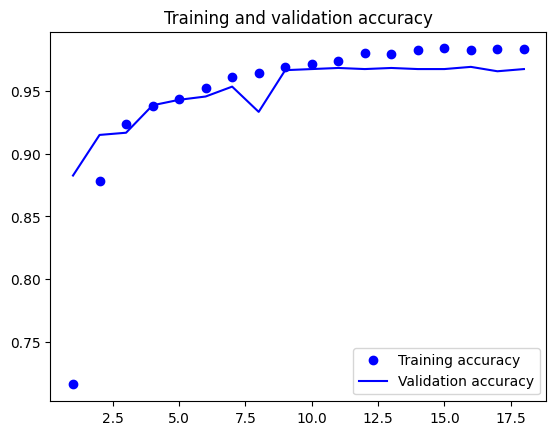

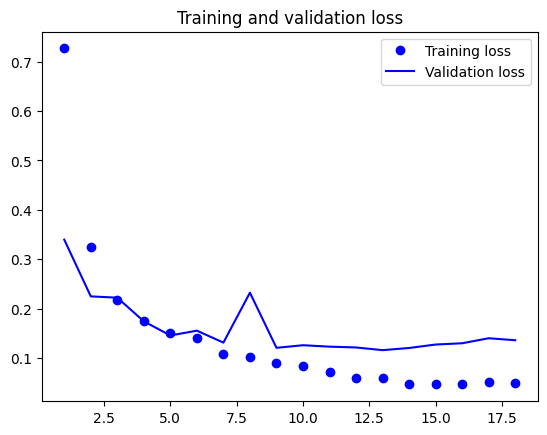

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.97      0.99       300
meningioma_tumor       0.97      0.94      0.96       306
        no_tumor       0.99      1.00      0.99       405
 pituitary_tumor       0.95      1.00      0.97       300

        accuracy                           0.98      1311
       macro avg       0.98      0.98      0.98      1311
    weighted avg       0.98      0.98      0.98      1311



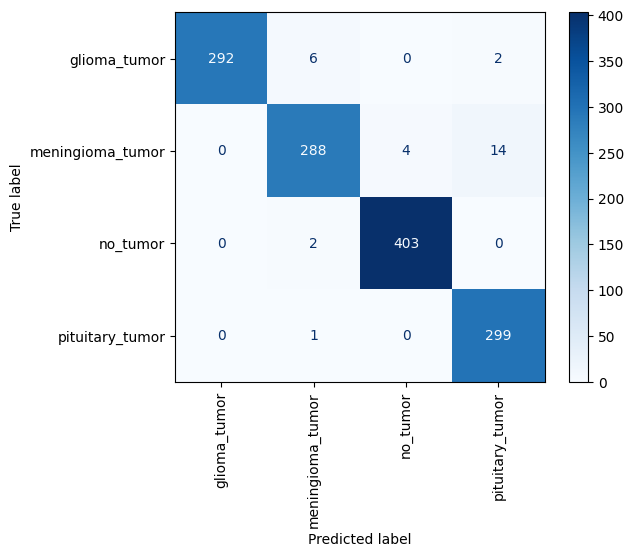

In [ ]:
# Generate batches for training and validation (80/20 split)
train_dataset, validation_dataset = image_dataset_from_directory(base_dir / "Training",
                                                                 class_names=labels,
                                                                 image_size=(224, 224),
                                                                 batch_size=32,
                                                                 validation_split=0.2,
                                                                 subset="both",
                                                                 seed=42)

# Generate batches for testing
test_dataset = image_dataset_from_directory(base_dir / "Testing",
                                            class_names=labels,
                                            image_size=(224, 224),
                                            batch_size=32,
                                            seed=42)

# Label-preserving transformations
data_augmentation = keras.Sequential([
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.GaussianNoise(0.05),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Instantiate convolutional base of EfficientNetB0
conv_base = keras.applications.EfficientNetB0(
    weights="imagenet", include_top=False)

# Freeze first 100 layers for stability
for layer in conv_base.layers[:100]:
    layer.trainable = False

# Build model structure
model = keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    conv_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.7),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax')
])

# Configure loss function, optimizer and monitoring metric
optimizer = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

# Configure checkpoint, early stopping, reduce learning rate callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="efficientnetb0.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=callbacks
)

# Display curves of accuracy and loss during training
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Load the best model
best_model = keras.models.load_model("efficientnetb0.keras")

# Perform predictions on the test set
test_preds, test_truths = [], []
for data_batch, labels_batch in test_dataset:
    preds = best_model.predict_on_batch(data_batch).argmax(axis=1)
    test_preds.append(preds)
    test_truths.append(labels_batch.numpy())
test_preds = np.concatenate(test_preds)
test_truths = np.concatenate(test_truths)

# Evaluate the performance on test set
metrics = classification_report(test_truths, test_preds, target_names=labels)
print(metrics)

# Plot confusion matrix
conf_mat = confusion_matrix(test_truths, test_preds)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
conf_mat_disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.show()

# Model 5 - EfficientNetB0

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Epoch 1/20
143/143 [==============================] - 54s 334ms/step - loss: 0.5611 - accuracy: 0.7902 - val_loss: 0.3635 - val_accuracy: 0.8564 - lr: 1.0000e-04
Epoch 2/20
143/143 [==============================] - 47s 327ms/step - loss: 0.2359 - accuracy: 0.9116 - val_loss: 0.1756 - val_accuracy: 0.9343 - lr: 1.0000e-04
Epoch 3/20
143/143 [==============================] - 47s 329ms/step - loss: 0.1756 - accuracy: 0.9359 - val_loss: 0.1695 - val_accuracy: 0.9413 - lr: 1.0000e-04
Epoch 4/20
143/143 [==============================] - 47s 331ms/step - loss: 0.1460 - accuracy: 0.9466 - val_loss: 0.1614 - val_accuracy: 0.9413 - lr: 1.0000e-04
Epoch 5/20
143/143 [==============================] - 47s 329ms/step - loss: 0.1210 - accuracy: 0.9567 - val_loss: 0.1425 - val_accuracy: 0.9475 - lr: 1.0000e-04
Epoch 6/20
143/143 [========================

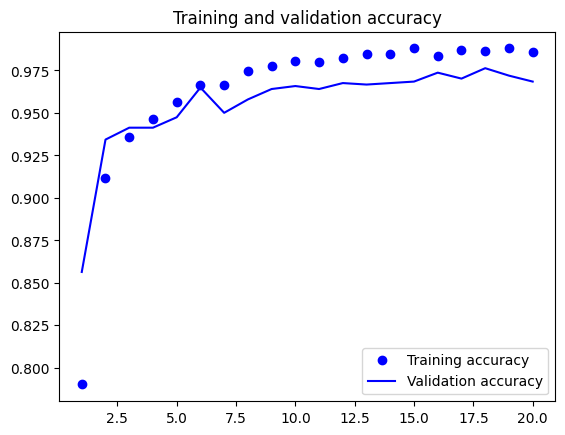

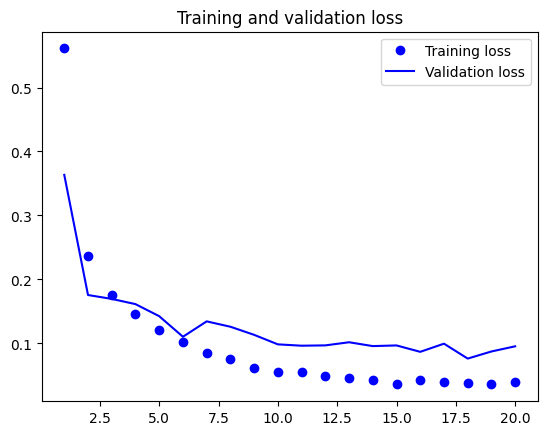

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.93      0.96       300
meningioma_tumor       0.94      0.95      0.95       306
        no_tumor       1.00      1.00      1.00       405
 pituitary_tumor       0.95      1.00      0.97       300

        accuracy                           0.97      1311
       macro avg       0.97      0.97      0.97      1311
    weighted avg       0.97      0.97      0.97      1311



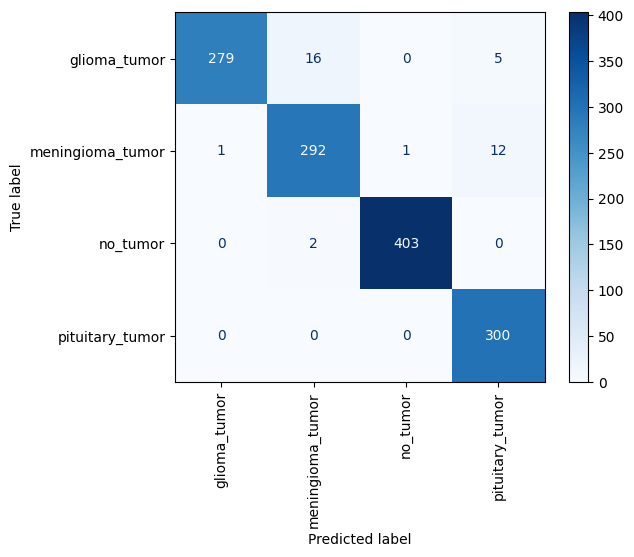

In [ ]:
# Generate batches for training and validation (80/20 split)
train_dataset, validation_dataset = image_dataset_from_directory(base_dir / "Training",
                                                                 class_names=labels,
                                                                 image_size=(224, 224),
                                                                 batch_size=32,
                                                                 validation_split=0.2,
                                                                 subset="both",
                                                                 seed=42)

# Generate batches for testing
test_dataset = image_dataset_from_directory(base_dir / "Testing",
                                            class_names=labels,
                                            image_size=(224, 224),
                                            batch_size=32,
                                            seed=42)

# Label-preserving transformations
data_augmentation = keras.Sequential([
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.GaussianNoise(0.05),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Instantiate convolutional base of EfficientNetB0
conv_base = keras.applications.EfficientNetB0(
    weights="imagenet", include_top=False)

# Freeze first 100 layers for stability
for layer in conv_base.layers[:100]:
    layer.trainable = False

# Build model structure
model = keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    conv_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax')
])

# Configure loss function, optimizer and monitoring metric
optimizer = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

# Configure checkpoint, early stopping, reduce learning rate callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="efficientnetb0.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

# Train Model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=callbacks
)

# Plot Accuracy and Loss Curves
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Load the best model
best_model = keras.models.load_model("efficientnetb0.keras")

# Perform predictions on the test set
test_preds, test_truths = [], []
for data_batch, labels_batch in test_dataset:
    preds = best_model.predict_on_batch(data_batch).argmax(axis=1)
    test_preds.append(preds)
    test_truths.append(labels_batch.numpy())
test_preds = np.concatenate(test_preds)
test_truths = np.concatenate(test_truths)

# Evaluate the performance on test set
metrics = classification_report(test_truths, test_preds, target_names=labels)
print(metrics)

# Confusion Matrix
conf_mat = confusion_matrix(test_truths, test_preds)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
conf_mat_disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.show()

# Model 6 - EfficientNetB0

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Epoch 1/100
143/143 [==============================] - 56s 344ms/step - loss: 0.7801 - accuracy: 0.6849 - val_loss: 0.4118 - val_accuracy: 0.8441 - lr: 1.0000e-04
Epoch 2/100
143/143 [==============================] - 47s 331ms/step - loss: 0.3490 - accuracy: 0.8720 - val_loss: 0.3001 - val_accuracy: 0.8932 - lr: 1.0000e-04
Epoch 3/100
143/143 [==============================] - 47s 331ms/step - loss: 0.2251 - accuracy: 0.9214 - val_loss: 0.2218 - val_accuracy: 0.9247 - lr: 1.0000e-04
Epoch 4/100
143/143 [==============================] - 48s 333ms/step - loss: 0.1809 - accuracy: 0.9352 - val_loss: 0.2216 - val_accuracy: 0.9247 - lr: 1.0000e-04
Epoch 5/100
143/143 [==============================] - 48s 334ms/step - loss: 0.1602 - accuracy: 0.9429 - val_loss: 0.2024 - val_accuracy: 0.9273 - lr: 1.0000e-04
Epoch 6/100
143/143 [==================

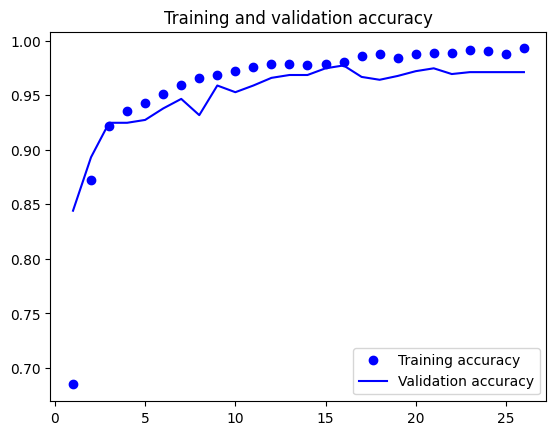

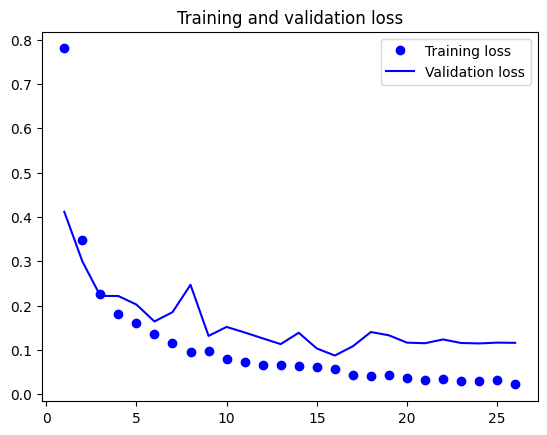

                  precision    recall  f1-score   support

    glioma_tumor       0.98      0.98      0.98       300
meningioma_tumor       0.97      0.95      0.96       306
        no_tumor       0.99      1.00      0.99       405
 pituitary_tumor       0.97      0.99      0.98       300

        accuracy                           0.98      1311
       macro avg       0.98      0.98      0.98      1311
    weighted avg       0.98      0.98      0.98      1311



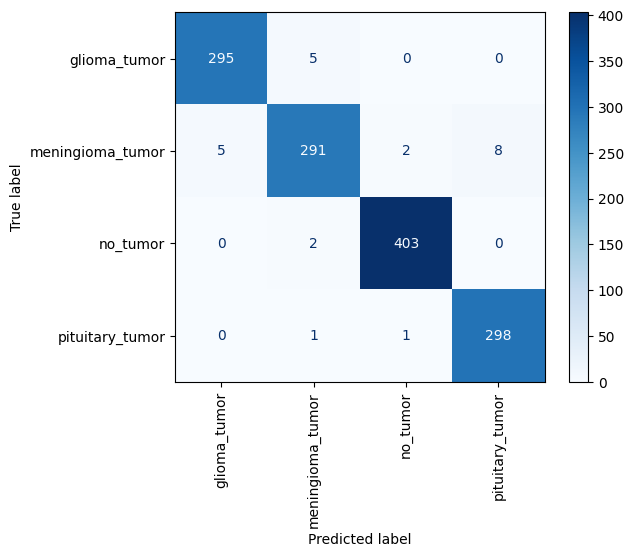

In [ ]:
# Generate batches for training and validation (80/20 split)
train_dataset, validation_dataset = image_dataset_from_directory(base_dir / "Training",
                                                                 class_names=labels,
                                                                 image_size=(224, 224),
                                                                 batch_size=32,
                                                                 validation_split=0.2,
                                                                 subset="both",
                                                                 seed=42)

# Generate batches for testing
test_dataset = image_dataset_from_directory(base_dir / "Testing",
                                            class_names=labels,
                                            image_size=(224, 224),
                                            batch_size=32,
                                            seed=42)

# Label-preserving transformations
data_augmentation = keras.Sequential([
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.GaussianNoise(0.05),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Instantiate convolutional base of EfficientNetB0
conv_base = keras.applications.EfficientNetB0(
    weights="imagenet", include_top=False)

# Freeze first 100 layers for stability
for layer in conv_base.layers[:100]:
    layer.trainable = False

# Build model structure
model = keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    conv_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.7),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax')
])

# Configure loss function, optimizer and monitoring metric
optimizer = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

# Configure checkpoint, early stopping, reduce learning rate callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="efficientnetb0.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

# Train Model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=callbacks
)

# Plot Accuracy and Loss Curves
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Load the best model
best_model = keras.models.load_model("efficientnetb0.keras")

# Perform predictions on the test set
test_preds, test_truths = [], []
for data_batch, labels_batch in test_dataset:
    preds = best_model.predict_on_batch(data_batch).argmax(axis=1)
    test_preds.append(preds)
    test_truths.append(labels_batch.numpy())
test_preds = np.concatenate(test_preds)
test_truths = np.concatenate(test_truths)

# Evaluate the performance on test set
metrics = classification_report(test_truths, test_preds, target_names=labels)
print(metrics)

# Confusion Matrix
conf_mat = confusion_matrix(test_truths, test_preds)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
conf_mat_disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.show()

# Model 7 - EfficientNetB0

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Epoch 1/50
143/143 [==============================] - 55s 345ms/step - loss: 0.7629 - accuracy: 0.7418 - val_loss: 0.6003 - val_accuracy: 0.7653 - lr: 1.1000e-04
Epoch 2/50
143/143 [==============================] - 45s 316ms/step - loss: 0.3690 - accuracy: 0.8746 - val_loss: 0.2880 - val_accuracy: 0.9011 - lr: 1.2000e-04
Epoch 3/50
143/143 [==============================] - 45s 315ms/step - loss: 0.2606 - accuracy: 0.9077 - val_loss: 0.3558 - val_accuracy: 0.8879 - lr: 1.3000e-04
Epoch 4/50
143/143 [==============================] - 46s 320ms/step - loss: 0.2130 - accuracy: 0.9315 - val_loss: 0.2487 - val_accuracy: 0.9159 - lr: 1.3000e-04
Epoch 5/50
143/143 [==============================] - 45s 318ms/step - loss: 0.1573 - accuracy: 0.9486 - val_loss: 0.2087 - val_accuracy: 0.9326 - lr: 1.3000e-04
Epoch 6/50
143/143 [========================

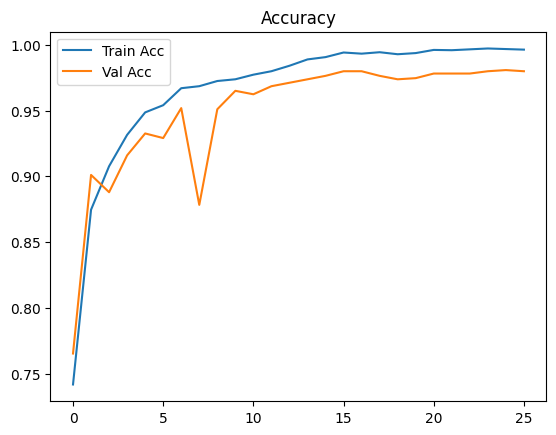

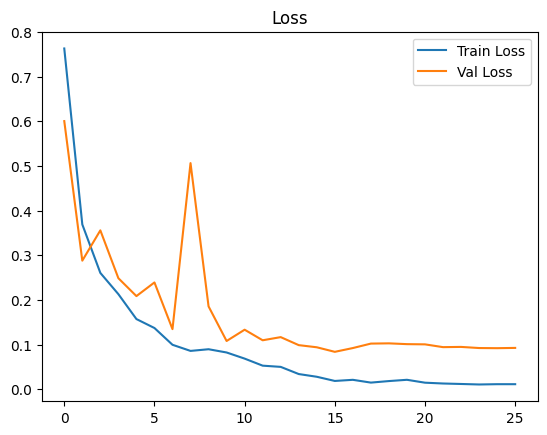

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.95      0.97       300
meningioma_tumor       0.95      0.96      0.96       306
        no_tumor       1.00      1.00      1.00       405
 pituitary_tumor       0.96      0.99      0.98       300

        accuracy                           0.98      1311
       macro avg       0.98      0.98      0.98      1311
    weighted avg       0.98      0.98      0.98      1311



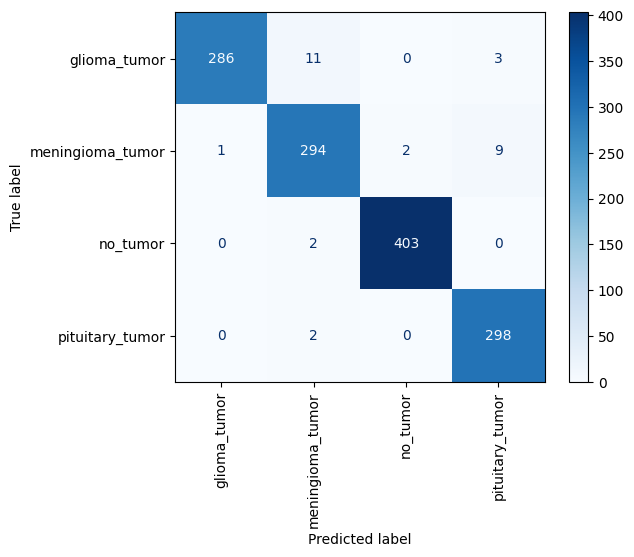

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Dataset Setup
image_size = (224, 224)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Generate batches for training and validation (80/20 split)
train_dataset, validation_dataset = image_dataset_from_directory(
    base_dir / "Training",
    class_names=labels,
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="both",
    seed=42
)

# Generate batches for testing
test_dataset = image_dataset_from_directory(
    base_dir / "Testing",
    class_names=labels,
    image_size=image_size,
    batch_size=batch_size,
    seed=42
)

# Prefetch for performance
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Estimate class weights
y_train = np.concatenate([y for _, y in train_dataset], axis=0)
class_weights = dict(enumerate(compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)))

# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.GaussianNoise(0.05),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Base Model: EfficientNetB0
base_model = keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False  # freeze first 100 layers

# Functional Model
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs, outputs)

# === Compile ===
optimizer = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Learning Rate Scheduler
def warmup_schedule(epoch, lr):
    if epoch < 3:
        return lr + 1e-5
    return lr

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("efficientnetb0.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    keras.callbacks.LearningRateScheduler(warmup_schedule)
]

# Training
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weights
)

# Plot Accuracy & Loss
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()
plt.show()

# Evaluation
best_model = keras.models.load_model("efficientnetb0.keras")

test_preds, test_truths = [], []
for data_batch, labels_batch in test_dataset:
    preds = best_model.predict_on_batch(data_batch).argmax(axis=1)
    test_preds.append(preds)
    test_truths.append(labels_batch.numpy())
test_preds = np.concatenate(test_preds)
test_truths = np.concatenate(test_truths)

# Metric
print(classification_report(test_truths, test_preds, target_names=labels))
conf_mat = confusion_matrix(test_truths, test_preds)
ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels).plot(xticks_rotation='vertical', cmap='Blues')
plt.show()

# Model 8 - EfficientNetB0

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Epoch 1/50
143/143 [==============================] - 55s 330ms/step - loss: 0.8671 - accuracy: 0.6915 - val_loss: 0.4839 - val_accuracy: 0.8187 - lr: 1.1000e-04
Epoch 2/50
143/143 [==============================] - 47s 325ms/step - loss: 0.4593 - accuracy: 0.8545 - val_loss: 0.4723 - val_accuracy: 0.8433 - lr: 1.2000e-04
Epoch 3/50
143/143 [==============================] - 46s 322ms/step - loss: 0.2968 - accuracy: 0.8976 - val_loss: 0.2698 - val_accuracy: 0.9028 - lr: 1.3000e-04
Epoch 4/50
143/143 [==============================] - 47s 329ms/step - loss: 0.2292 - accuracy: 0.9247 - val_loss: 0.2164 - val_accuracy: 0.9291 - lr: 1.3000e-04
Epoch 5/50
143/143 [==============================] - 46s 325ms/step - loss: 0.1817 - accuracy: 0.9379 - val_loss: 0.2157 - val_accuracy: 0.9229 - lr: 1.3000e-04
Epoch 6/50
143/143 [========================

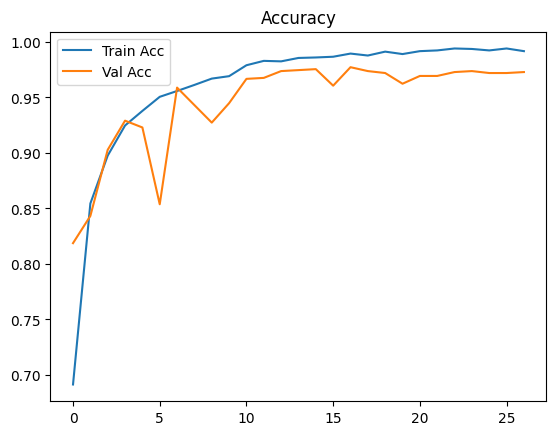

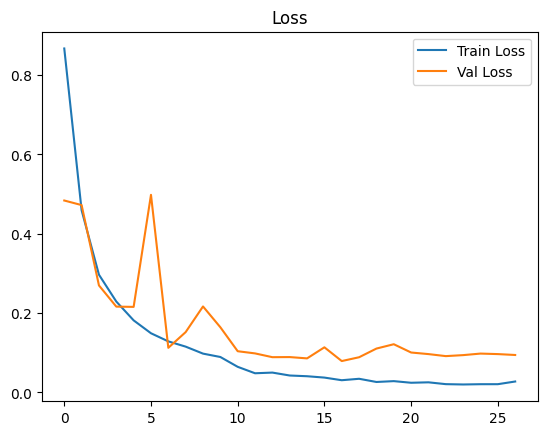

                  precision    recall  f1-score   support

    glioma_tumor       0.98      0.98      0.98       300
meningioma_tumor       0.98      0.94      0.96       306
        no_tumor       0.99      1.00      0.99       405
 pituitary_tumor       0.96      1.00      0.98       300

        accuracy                           0.98      1311
       macro avg       0.98      0.98      0.98      1311
    weighted avg       0.98      0.98      0.98      1311



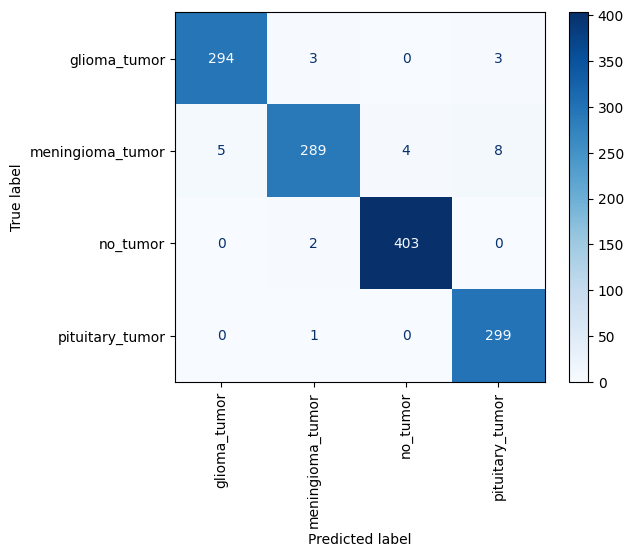

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

# Dataset Setup
image_size = (224, 224)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Generate batches for training and validation (80/20 split)
train_dataset, validation_dataset = image_dataset_from_directory(
    base_dir / "Training",
    class_names=labels,
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="both",
    seed=42
)

# Generate batches for testing
test_dataset = image_dataset_from_directory(
    base_dir / "Testing",
    class_names=labels,
    image_size=image_size,
    batch_size=batch_size,
    seed=42
)

# Prefetch for performance
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Estimate class weights
y_train = np.concatenate([y for _, y in train_dataset], axis=0)
class_weights = dict(enumerate(compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)))

# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.GaussianNoise(0.05),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name="data_augmentation")

# Base Model
base_model = keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False  # Freeze early layers

# Functional Model
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs, outputs)

# Optimizer & Loss
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# To schedule learning rate
def warmup_schedule(epoch, lr):
    if epoch < 3:
        return lr + 1e-5
    return lr

# To unfreeze entire base on epoch 10
class UnfreezeCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 10:
            print("Unfreezing full EfficientNetB0")
            for layer in base_model.layers:
                layer.trainable = True

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("efficientnetb0.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    keras.callbacks.LearningRateScheduler(warmup_schedule),
    UnfreezeCallback()
]

# Training
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weights
)

# Plot Accuracy & Loss
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()
plt.show()

# Evaluation
best_model = keras.models.load_model("efficientnetb0.keras")

test_preds, test_truths = [], []
for data_batch, labels_batch in test_dataset:
    preds = best_model.predict_on_batch(data_batch).argmax(axis=1)
    test_preds.append(preds)
    test_truths.append(labels_batch.numpy())
test_preds = np.concatenate(test_preds)
test_truths = np.concatenate(test_truths)

# Metric
print(classification_report(test_truths, test_preds, target_names=labels))
conf_mat = confusion_matrix(test_truths, test_preds)
ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels).plot(xticks_rotation='vertical', cmap='Blues')
plt.show()